# Challenge TOTVS — Clusterização de Clientes
**Turma:** 2TSCPV • **Grupo:** Data.fy  
**Integrantes:** Guilherme Miró - 99971 , Giovanni Pereira 555582, Aurelio de Jesus 96027, Arthur Favero 556694 — **Representante:** Maria Julia - 558195



1) Import & configs

Neste passo, importamos todas as bibliotecas que serão utilizadas ao longo do projeto. Usamos pandas e numpy para manipulação e análise de dados, scikit-learn para o pré-processamento, modelagem e métricas de avaliação.

In [ ]:
import os, glob, csv
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


2 ) Pré-processamento dos dados


Antes de aplicar o modelo, foi necessário organizar as bases. Realizamos a limpeza de colunas, padronização de nomes, tratamento de valores ausentes e conversão de variáveis categóricas em dummies (variáveis binárias). Também aplicamos a normalização com StandardScaler, que ajusta todas as variáveis numéricas para a mesma escala, evitando que atributos com valores maiores dominem o cálculo de distâncias no K-Means.

In [ ]:
pd.set_option("display.max_columns", 200)

BASE_PATH = "."
CLIENTES_FILE = os.path.join(BASE_PATH, "dados_clientes.csv")
MRR_FILE = os.path.join(BASE_PATH, "mrr.csv")
TICKETS_FILE = os.path.join(BASE_PATH, "tickets.csv")

NPS_FILES = {
    "relacional": os.path.join(BASE_PATH, "nps_relacional.csv"),
    "trans_aquisicao": os.path.join(BASE_PATH, "nps_transacional_aquisicao.csv"),
    "trans_implantacao": os.path.join(BASE_PATH, "nps_transacional_implantacao.csv"),
    "trans_onboarding": os.path.join(BASE_PATH, "nps_transacional_onboarding.csv"),
    "trans_produto": os.path.join(BASE_PATH, "nps_transacional_produto.csv"),
    "trans_suporte": os.path.join(BASE_PATH, "nps_transacional_suporte.csv"),
}

TELEMETRIA_FILES = sorted(glob.glob(os.path.join(BASE_PATH, "telemetria_*.csv")))

def to_datetime(series):
    return pd.to_datetime(series, errors="coerce", dayfirst=True, infer_datetime_format=True)

def clean_cols(df):
    df = df.copy()
    df.columns = [str(c).strip().lower() for c in df.columns]
    return df


In [ ]:
try:
    clientes = pd.read_csv(CLIENTES_FILE, sep=";", dtype=str, encoding="utf-8-sig")
except Exception:
    with open(CLIENTES_FILE, "rb") as f:
        raw_start = f.read(2048)

    for enc in ["utf-8-sig", "utf-8", "latin1", "cp1252"]:
        try:
            sample = raw_start.decode(enc, errors="ignore")
            dialect = csv.Sniffer().sniff(sample, delimiters=[",",";","\t","|"])
            clientes = pd.read_csv(CLIENTES_FILE, dtype=str, encoding=enc, sep=dialect.delimiter, engine="python")
            break
        except Exception:
            continue
    else:
        clientes = pd.read_csv(CLIENTES_FILE, dtype=str, sep=None, engine="python")

clientes = clean_cols(clientes)

id_candidates = [c for c in clientes.columns if c.upper() == "CD_CLIENTE" or c == "cd_cliente"]
if not id_candidates:
    raise ValueError(f"Não achei a coluna CD_CLIENTE em dados_clientes.csv. Colunas lidas: {clientes.columns.tolist()}")
clientes = clientes.rename(columns={id_candidates[0]: "clienteid"})

if "vl_total_contrato" in clientes.columns:
    clientes["vl_total_contrato"] = (
        clientes["vl_total_contrato"]
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    clientes["vl_total_contrato"] = pd.to_numeric(clientes["vl_total_contrato"], errors="coerce")

keep_cols = [
    "clienteid","ds_segmento","ds_subsegmento","fat_faixa","marca_totvs",
    "periodicidade","situacao_contrato","uf","vl_total_contrato"
]
clientes = clientes[[c for c in keep_cols if c in clientes.columns]].drop_duplicates("clienteid")
clientes.head()


,clienteid,ds_segmento,ds_subsegmento,fat_faixa,marca_totvs,periodicidade,situacao_contrato,uf,vl_total_contrato
0,99958,SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,CROSS - TRADICIONAL,00 - Mensal,GRATUITO,SC,1.633817e+06
1,T00053,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,MANUFATURA - PARCEIRO,00 - Mensal,ATIVO,RJ,3.411556e+02
5,99069,VAREJO,VAREJO,Sem Informações de Faturamento,RH - CORE,00 - Mensal,GRATUITO,SP,4.203857e-03
10,T00336,MANUFATURA,BENS DURAVEIS,Faixa 08 - De 150 M ate 300 M,FLUIG - CORE,00 - Mensal,ATIVO,SP,8.703246e+01
11,T00018,SERVICOS,VIAGENS,"Faixa 02 - De 7,5 M ate 15 M",HOSPITALIDADE - CORE,00 - Mensal,CANCELADO,SP,4.203857e-01


In [ ]:
def build_telemetria_features(file_list):
    frames = []
    for f in file_list:
        df = pd.read_csv(f, dtype=str, low_memory=False)
        df = clean_cols(df)
        # esperadas: clienteid, eventduration, moduloid, productlineid, referencedatestart, statuslicenca, tcloud, clienteprime
        if "eventduration" in df.columns:
            df["eventduration"] = pd.to_numeric(df["eventduration"], errors="coerce")
        if "referencedatestart" in df.columns:
            df["referencedatestart"] = to_datetime(df["referencedatestart"])
        # Flags binárias, se existirem
        for bcol in ["statuslicenca","tcloud","clienteprime"]:
            if bcol in df.columns:
                s = df[bcol].astype(str).str.lower()
                df[bcol] = s.isin(["1","true","sim","yes","ativo","prime"]).astype(int)
        frames.append(df)

    if not frames:
        return pd.DataFrame(columns=["clienteid"])

    tel = pd.concat(frames, ignore_index=True)
    agg = {
        "eventduration": "sum",
        "moduloid": pd.Series.nunique if "moduloid" in tel.columns else "count",
        "productlineid": pd.Series.nunique if "productlineid" in tel.columns else "count",
        "referencedatestart": "max" if "referencedatestart" in tel.columns else "first",
    }
    for bcol in ["statuslicenca","tcloud","clienteprime"]:
        if bcol in tel.columns:
            agg[bcol] = "mean"

    tel_agg = tel.groupby("clienteid").agg(agg).reset_index()
    tel_agg = tel_agg.rename(columns={
        "eventduration": "tel_total_eventduration",
        "moduloid": "tel_n_modulos_distintos",
        "productlineid": "tel_n_productlines_distintos",
        "referencedatestart": "tel_dt_ultimo_uso",
        "statuslicenca": "tel_pct_licenca_ativa",
        "tcloud": "tel_pct_cloud",
        "clienteprime": "tel_pct_prime",
    })

    # recência
    if "tel_dt_ultimo_uso" in tel_agg.columns:
        ref = tel_agg["tel_dt_ultimo_uso"].max()
        tel_agg["tel_dias_desde_ultimo_uso"] = (ref - tel_agg["tel_dt_ultimo_uso"]).dt.days
        tel_agg = tel_agg.drop(columns=["tel_dt_ultimo_uso"], errors="ignore")

    # preencher nulos
    for c in ["tel_total_eventduration","tel_n_modulos_distintos","tel_n_productlines_distintos",
              "tel_pct_licenca_ativa","tel_pct_cloud","tel_pct_prime","tel_dias_desde_ultimo_uso"]:
        if c in tel_agg.columns:
            tel_agg[c] = pd.to_numeric(tel_agg[c], errors="coerce").fillna(0)

    return tel_agg

telemetria = build_telemetria_features(TELEMETRIA_FILES)
telemetria.head()


/tmp/ipython-input-4174679913.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipython-input-4174679913.py:20: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(series, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipython-input-4174679913.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, 

,clienteid,tel_total_eventduration,tel_n_modulos_distintos,tel_n_productlines_distintos,tel_pct_licenca_ativa,tel_pct_cloud,tel_pct_prime,tel_dias_desde_ultimo_uso
0,T0005300,9.926649e+06,37,3,0.0,0.0,0.0,0
1,T0008200,7.474155e+06,32,3,0.0,0.0,0.0,0
2,T0014500,6.329944e+06,16,2,0.0,0.0,0.0,0
3,T0024500,1.702782e+06,7,1,0.0,0.0,0.0,0
4,T0025500,5.048128e+05,5,2,0.0,0.0,0.0,0


In [ ]:
def read_csv_robust(path):
    try:
        return pd.read_csv(path, sep=";", dtype=str, encoding="utf-8-sig")
    except Exception:
        pass

    with open(path, "rb") as f:
        start = f.read(4096)

    for enc in ["utf-8-sig", "utf-8", "latin1", "cp1252"]:
        try:
            sample = start.decode(enc, errors="ignore")
            dialect = csv.Sniffer().sniff(sample, delimiters=[",",";","\t","|"])
            return pd.read_csv(path, dtype=str, encoding=enc, sep=dialect.delimiter, engine="python", quoting=csv.QUOTE_MINIMAL)
        except Exception:
            continue

    try:
        return pd.read_csv(path, dtype=str, sep=None, engine="python")
    except Exception:
        return pd.read_csv(path, dtype=str, sep=None, engine="python", on_bad_lines="skip")

tickets = read_csv_robust(TICKETS_FILE)
tickets = clean_cols(tickets)

id_t = [c for c in tickets.columns if c.upper() == "CODIGO_ORGANIZACAO" or c == "codigo_organizacao"]
if not id_t:
    raise ValueError(f"Não achei CODIGO_ORGANIZACAO em tickets.csv. Colunas: {tickets.columns.tolist()}")
tickets = tickets.rename(columns={id_t[0]: "clienteid"})


for dcol in ["dt_criacao","dt_atualizacao"]:
    if dcol in tickets.columns:
        tickets[dcol] = to_datetime(tickets[dcol])

if set(["dt_criacao","dt_atualizacao"]).issubset(tickets.columns):
    tickets["tempo_resolucao_dias"] = (
        tickets["dt_atualizacao"] - tickets["dt_criacao"]
    ).dt.total_seconds() / (3600*24)

if "bk_ticket" not in tickets.columns:
    tickets["bk_ticket"] = 1


agg = {"bk_ticket": "count"}
if "tempo_resolucao_dias" in tickets.columns:
    agg["tempo_resolucao_dias"] = "mean"

tick_agg = (
    tickets.groupby("clienteid")
    .agg(agg)
    .reset_index()
    .rename(columns={"bk_ticket":"tick_qtd","tempo_resolucao_dias":"tick_tempo_medio_resolucao_dias"})
)

if "status_ticket" in tickets.columns:
    st = tickets.pivot_table(index="clienteid", columns="status_ticket", values="bk_ticket",
                             aggfunc="count", fill_value=0)
    closed_cols = [c for c in st.columns if c.lower() in {"closed","solved"}]
    st["tick_closed"] = st[closed_cols].sum(axis=1) if closed_cols else 0
    st["tick_total_status"] = st.sum(axis=1)
    st["tick_close_rate"] = np.where(st["tick_total_status"]>0, st["tick_closed"]/st["tick_total_status"], 0)
    st = st.reset_index()[["clienteid","tick_close_rate"]]
    tick_agg = tick_agg.merge(st, on="clienteid", how="left")

tick_agg = tick_agg.fillna({"tick_qtd":0, "tick_tempo_medio_resolucao_dias":0, "tick_close_rate":0})
tick_agg.head()


/tmp/ipython-input-4174679913.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipython-input-4174679913.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", dayfirst=True, infer_datetime_format=True)


,clienteid,tick_qtd,tick_tempo_medio_resolucao_dias,tick_close_rate
0,T00018,2,46.500000,0.500000
1,T00053,326,115.918919,0.496914
2,T00082,261,2.800000,0.493204
3,T00145,54,101.583333,0.480769
4,T00151,68,14.266667,0.496296


In [ ]:
def nps_trans_features(path, key_candidates):
    if not os.path.exists(path):
        return pd.DataFrame(columns=["clienteid","nps_trans_medio","nps_trans_qtd"])

    df = clean_cols(read_csv_robust(path))

    key = next((k for k in [k.lower() for k in key_candidates] if k in df.columns), None)
    if key is None:
        return pd.DataFrame(columns=["clienteid","nps_trans_medio","nps_trans_qtd"])
    df = df.rename(columns={key: "clienteid"})

    cand_notas = [c for c in df.columns if ("nps" in c or "nota" in c)]
    cand_notas = [c for c in cand_notas if c not in {"clienteid","cód. cliente","cod. cliente","cod cliente","metadata_codcliente"}]

    prefer = [c for c in ["nota nps","resposta_nps","nota"] if c in df.columns]
    if prefer:
        cand_notas = prefer

    if not cand_notas:
        qcols = []
        for c in df.columns:
            if c in {"clienteid","data de resposta","respondedat","data_da_resposta","data_resposta"}:
                continue
            s = pd.to_numeric(df[c], errors="coerce")
            if s.between(0, 10).mean() >= 0.5:
                qcols.append(c)
        cand_notas = qcols

    if not cand_notas:
        return pd.DataFrame(columns=["clienteid","nps_trans_medio","nps_trans_qtd"])

    cand_notas = list(dict.fromkeys(cand_notas))  # dedup
    if len(cand_notas) == 1:
        col = cand_notas[0]
        df[col] = pd.to_numeric(df[col], errors="coerce")
        nota_series = df[col]
    else:
        for c in cand_notas:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        nota_series = df[cand_notas].mean(axis=1)

    out = (
        pd.DataFrame({"clienteid": df["clienteid"], "nota": nota_series})
        .groupby("clienteid")["nota"]
        .agg(nps_trans_medio="mean", nps_trans_qtd="count")
        .reset_index()
    )
    return out


In [ ]:
nps_aq   = nps_trans_features(NPS_FILES["trans_aquisicao"],   ["Cód. Cliente","cod. cliente","cod cliente","cliente","metadata_codcliente"])
nps_impl = nps_trans_features(NPS_FILES["trans_implantacao"], ["Cód. Cliente","cod. cliente","cod cliente","cliente"])
nps_onb  = nps_trans_features(NPS_FILES["trans_onboarding"],  ["Cod Cliente","Cód. Cliente","cod cliente","cliente","metadata_codcliente"])
nps_prod = nps_trans_features(NPS_FILES["trans_produto"],     ["Cód. T","cod. t","cliente","metadata_codcliente"])
nps_sup  = nps_trans_features(NPS_FILES["trans_suporte"],     ["cliente","metadata_codcliente","Cód. Cliente","cod cliente"])

frames = [df for df in [nps_aq,nps_impl,nps_onb,nps_prod,nps_sup] if not df.empty]
nps_trans_all = (pd.concat(frames, ignore_index=True)
                 .groupby("clienteid")
                 .agg(nps_trans_medio=("nps_trans_medio","mean"),
                      nps_trans_qtd=("nps_trans_qtd","sum"))
                 .reset_index()) if frames else pd.DataFrame(columns=["clienteid","nps_trans_medio","nps_trans_qtd"])


In [ ]:

def nps_onboarding_features(file_path):
    df = read_csv_robust(file_path)
    df = clean_cols(df)

    if "clienteid" not in df.columns:
        for cand in ["cod cliente","cód. cliente","cod. cliente","cliente","metadata_codcliente"]:
            if cand in df.columns:
                df = df.rename(columns={cand: "clienteid"})
                break
    if "clienteid" not in df.columns:
        raise ValueError(f"Não achei coluna de cliente em {file_path}. Colunas: {df.columns.tolist()}")

    explicit_q = "em uma escala de 0 a 10, quanto você recomenda o onboarding da totvs para um amigo ou colega?."
    explicit_q = explicit_q.lower()
    if explicit_q in df.columns:
        s = pd.to_numeric(df[explicit_q], errors="coerce")
        out = (
            pd.DataFrame({"clienteid": df["clienteid"], "score": s})
            .groupby("clienteid", as_index=False)["score"].mean()
            .rename(columns={"score": "nps_transacional_onboarding"})
        )
        return out

    question_cols = []
    for c in df.columns:
        if c in {"clienteid","data de resposta","respondedat","data_da_resposta","data_resposta"}:
            continue
        header_hit = ("0 a 10" in c) or ("escala" in c) or c.startswith("- ")
        s = pd.to_numeric(df[c], errors="coerce")
        valid_ratio = s.between(0, 10).mean()  # proporção de valores válidos
        if header_hit or valid_ratio >= 0.5:
            question_cols.append(c)

    if not question_cols:
        raise ValueError(
            f"Não identifiquei colunas de pontuação 0–10 em {file_path}. "
            f"Colunas: {df.columns.tolist()}"
        )

    scores = df[["clienteid"] + question_cols].copy()
    for c in question_cols:
        scores[c] = pd.to_numeric(scores[c], errors="coerce")
    scores["nps_transacional_onboarding"] = scores[question_cols].mean(axis=1, skipna=True)

    out = (
        scores.groupby("clienteid", as_index=False)["nps_transacional_onboarding"].mean()
    )
    return out

nps_onb = nps_onboarding_features(NPS_FILES["trans_onboarding"])


In [ ]:
def rename_nps(df, prefix):
    if df is None or (hasattr(df, "empty") and df.empty):
        return pd.DataFrame(columns=["clienteid", f"{prefix}_medio", f"{prefix}_qtd"])
    df = df.copy()
    if {"nps_rel_medio","nps_rel_qtd"}.issubset(df.columns):
        df = df.rename(columns={"nps_rel_medio": f"{prefix}_medio",
                                "nps_rel_qtd":   f"{prefix}_qtd"})
    elif {"nps_trans_medio","nps_trans_qtd"}.issubset(df.columns):
        df = df.rename(columns={"nps_trans_medio": f"{prefix}_medio",
                                "nps_trans_qtd":   f"{prefix}_qtd"})
    else:
        for c in [f"{prefix}_medio", f"{prefix}_qtd"]:
            if c not in df.columns: df[c] = 0
    return df[["clienteid", f"{prefix}_medio", f"{prefix}_qtd"]].drop_duplicates()

globals_dict = globals()
nps_rel  = rename_nps(globals_dict.get("nps_rel",  pd.DataFrame()), "nps_rel")
nps_aq   = rename_nps(globals_dict.get("nps_aq",   pd.DataFrame()), "nps_aq")
nps_impl = rename_nps(globals_dict.get("nps_impl", pd.DataFrame()), "nps_impl")
nps_onb  = rename_nps(globals_dict.get("nps_onb",  pd.DataFrame()), "nps_onb")
nps_prod = rename_nps(globals_dict.get("nps_prod", pd.DataFrame()), "nps_prod")
nps_supp = rename_nps(globals_dict.get("nps_supp", pd.DataFrame()), "nps_supp")

nps_all = nps_rel
for df_tmp in [nps_aq, nps_impl, nps_onb, nps_prod, nps_supp]:
    nps_all = nps_all.merge(df_tmp, on="clienteid", how="outer")

nps_all = nps_all.fillna(0)

pairs = [
    ("nps_aq_medio","nps_aq_qtd"),
    ("nps_impl_medio","nps_impl_qtd"),
    ("nps_onb_medio","nps_onb_qtd"),
    ("nps_prod_medio","nps_prod_qtd"),
    ("nps_supp_medio","nps_supp_qtd"),
]

for m, q in pairs:
    if m not in nps_all.columns: nps_all[m] = 0
    if q not in nps_all.columns: nps_all[q] = 0

num = 0
den = 0
for m, q in pairs:
    num = num + (pd.to_numeric(nps_all[m], errors="coerce").fillna(0) * pd.to_numeric(nps_all[q], errors="coerce").fillna(0))
    den = den + pd.to_numeric(nps_all[q], errors="coerce").fillna(0)

nps_all["nps_trans_qtd"]   = den
nps_all["nps_trans_medio"] = np.where(den > 0, num / den, 0)

nps_all.head()


/tmp/ipython-input-3516064230.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nps_all = nps_all.fillna(0)


,clienteid,nps_rel_medio,nps_rel_qtd,nps_aq_medio,nps_aq_qtd,nps_impl_medio,nps_impl_qtd,nps_onb_medio,nps_onb_qtd,nps_prod_medio,nps_prod_qtd,nps_supp_medio,nps_supp_qtd,nps_trans_qtd,nps_trans_medio
0,000001,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.908046,87.0,0,0,87.0,8.908046
1,000002,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.647059,17.0,0,0,17.0,7.647059
2,000003,0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.750000,20.0,0,0,20.0,9.750000
3,000006,0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.500000,18.0,0,0,18.0,9.500000
4,000008,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.107143,28.0,0,0,28.0,6.107143


MRR por cliente

Padronizamos o campo monetário mrr_12m, convertendo para numérico tratando . e , e unimos por clienteid. Isso permite comparar perfil de valor entre clusters.

In [ ]:
def read_csv_robust(path, sep_candidates=[",",";","\t","|"]):
    try:
        return pd.read_csv(path, sep=";", dtype=str, encoding="utf-8-sig")
    except Exception:
        pass
    with open(path, "rb") as f:
        start = f.read(4096)
    for enc in ["utf-8-sig", "utf-8", "latin1", "cp1252"]:
        try:
            sample = start.decode(enc, errors="ignore")
            dialect = csv.Sniffer().sniff(sample, delimiters=sep_candidates)
            return pd.read_csv(path, dtype=str, encoding=enc, sep=dialect.delimiter, engine="python")
        except Exception:
            continue
    return pd.read_csv(path, dtype=str, sep=None, engine="python", on_bad_lines="skip")

mrr = clean_cols(read_csv_robust(MRR_FILE))

id_mrr = next((c for c in mrr.columns if c.upper() in {"CLIENTE","CD_CLIENTE"}), None)
if id_mrr is None:
    raise ValueError(f"Não achei CLIENTE/CD_CLIENTE em {MRR_FILE}. Colunas: {mrr.columns.tolist()}")
mrr = mrr.rename(columns={id_mrr: "clienteid"})

val_col = next((c for c in mrr.columns if c.lower() == "mrr_12m"), None)
if val_col is None:
    val_col = next((c for c in mrr.columns if "mrr" in c.lower()), None)

if val_col:
    mrr[val_col] = (
        mrr[val_col]
        .str.replace(r"\.", "", regex=True)
        .str.replace(",", ".", regex=False)
    )
    mrr[val_col] = pd.to_numeric(mrr[val_col], errors="coerce")
    mrr = mrr.rename(columns={val_col: "mrr_12m"})
else:
    mrr["mrr_12m"] = np.nan

mrr = mrr[["clienteid","mrr_12m"]].drop_duplicates()
mrr.head()


,clienteid,mrr_12m
0,T03360,485245250
1,T01872,287070309
2,T01899,628717296
3,T01670,207503636
4,T02817,890027855


Base consolidada para modelageM

Unimos **tickets + NPS + MRR** por `clienteid`, formando a base única usada no modelo e no dashboard. Nesta etapa garantimos que colunas numéricas estejam coerentes (conversão para `float`) e substituímos ausências por `0` quando adequado.

In [ ]:

base = (
    clientes
    .merge(telemetria, on="clienteid", how="left")
    .merge(tick_agg,   on="clienteid", how="left")
    .merge(nps_all,    on="clienteid", how="left")
    .merge(mrr,        on="clienteid", how="left")
)

num_fill_zeros = [
    "tel_total_eventduration","tel_n_modulos_distintos","tel_n_productlines_distintos",
    "tel_pct_licenca_ativa","tel_pct_cloud","tel_pct_prime","tel_dias_desde_ultimo_uso",
    "tick_qtd","tick_tempo_medio_resolucao_dias","tick_close_rate",
    "mrr_12m","vl_total_contrato"
]
for c in num_fill_zeros:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce").fillna(0)

for c in [col for col in base.columns if col.startswith("nps_")]:
    base[c] = pd.to_numeric(base[c], errors="coerce").fillna(0)

print(base.shape)
base.head()


(10615, 34)


,clienteid,ds_segmento,ds_subsegmento,fat_faixa,marca_totvs,periodicidade,situacao_contrato,uf,vl_total_contrato,tel_total_eventduration,tel_n_modulos_distintos,tel_n_productlines_distintos,tel_pct_licenca_ativa,tel_pct_cloud,tel_pct_prime,tel_dias_desde_ultimo_uso,tick_qtd,tick_tempo_medio_resolucao_dias,tick_close_rate,nps_rel_medio,nps_rel_qtd,nps_aq_medio,nps_aq_qtd,nps_impl_medio,nps_impl_qtd,nps_onb_medio,nps_onb_qtd,nps_prod_medio,nps_prod_qtd,nps_supp_medio,nps_supp_qtd,nps_trans_qtd,nps_trans_medio,mrr_12m
0,99958,SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,CROSS - TRADICIONAL,00 - Mensal,GRATUITO,SC,1.633817e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00
1,T00053,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,MANUFATURA - PARCEIRO,00 - Mensal,ATIVO,RJ,3.411556e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326.0,115.918919,0.496914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,4.489518e+08
2,99069,VAREJO,VAREJO,Sem Informações de Faturamento,RH - CORE,00 - Mensal,GRATUITO,SP,4.203857e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00
3,T00336,MANUFATURA,BENS DURAVEIS,Faixa 08 - De 150 M ate 300 M,FLUIG - CORE,00 - Mensal,ATIVO,SP,8.703246e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.0,-1.351351,0.500000,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0,6.883117,77.0,0.0,0.0,79.0,6.962025,2.501361e+09
4,T00018,SERVICOS,VIAGENS,"Faixa 02 - De 7,5 M ate 15 M",HOSPITALIDADE - CORE,00 - Mensal,CANCELADO,SP,4.203857e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,46.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00


In [ ]:
cat_cols = [c for c in ["ds_segmento","ds_subsegmento","fat_faixa","marca_totvs","periodicidade","situacao_contrato","uf"] if c in base.columns]

num_cols_base = [
    "vl_total_contrato","mrr_12m",
    "tel_total_eventduration","tel_n_modulos_distintos","tel_n_productlines_distintos","tel_dias_desde_ultimo_uso",
    "tel_pct_licenca_ativa","tel_pct_cloud","tel_pct_prime",
    "tick_qtd","tick_tempo_medio_resolucao_dias","tick_close_rate",
]
num_cols = [c for c in (num_cols_base + [c for c in base.columns if c.startswith("nps_")]) if c in base.columns]

df = base.dropna(subset=["clienteid"]).copy()
for c in cat_cols:
    df[c] = df[c].astype("category")

X_num = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns=num_cols, index=df.index) if num_cols else pd.DataFrame(index=df.index)
X_cat = pd.get_dummies(df[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=df.index)
X = pd.concat([X_num, X_cat], axis=1)

print(f"Shape de X: {X.shape}")
X.head(3)


Shape de X: (10615, 246)


,vl_total_contrato,mrr_12m,tel_total_eventduration,tel_n_modulos_distintos,tel_n_productlines_distintos,tel_dias_desde_ultimo_uso,tel_pct_licenca_ativa,tel_pct_cloud,tel_pct_prime,tick_qtd,tick_tempo_medio_resolucao_dias,tick_close_rate,nps_rel_medio,nps_rel_qtd,nps_aq_medio,nps_aq_qtd,nps_impl_medio,nps_impl_qtd,nps_onb_medio,nps_onb_qtd,nps_prod_medio,nps_prod_qtd,nps_supp_medio,nps_supp_qtd,nps_trans_qtd,nps_trans_medio,ds_segmento_CONSTRUCAO E PROJETOS,ds_segmento_DISTRIBUICAO,ds_segmento_EDUCACIONAL,ds_segmento_FINANCIAL SERVICES,ds_segmento_HOSPITALITY,ds_segmento_JURIDICO,ds_segmento_LOGISTICA,ds_segmento_MANUFATURA,ds_segmento_SAUDE,ds_segmento_SERVICOS,ds_segmento_SUPERMERCADOS,ds_segmento_TOTVS,ds_segmento_VAREJO,ds_subsegmento_ATACADISTA E DISTRIBUIDOR,ds_subsegmento_BANCOS E FINANCEIRAS,ds_subsegmento_BASICO,ds_subsegmento_BENS DE CAPITAL,ds_subsegmento_BENS DE CONSUMO,ds_subsegmento_BENS DURAVEIS,ds_subsegmento_BPO,ds_subsegmento_CENTROS CLINICOS,ds_subsegmento_CLUBES,ds_subsegmento_CONCESSIONARIA DE VEICULOS,ds_subsegmento_CONDOMINIO,ds_subsegmento_CONSTRUTORAS,ds_subsegmento_COOPERATIVA AGROPECUARIA,ds_subsegmento_DROGARIA,ds_subsegmento_EDUCACAO CONTINUADA,ds_subsegmento_ENERGIA,ds_subsegmento_ENGENHARIA & DESIGN,ds_subsegmento_ESCRITORIO DE ADVOCACIA,ds_subsegmento_EXTRATIVISTA & BENEFICIAMENTO,ds_subsegmento_FINANCEIRO - CREDITO E FINANCIAMENTO,ds_subsegmento_FINANCEIRO - HOLDINGS,ds_subsegmento_FOOD,ds_subsegmento_GRAOS,ds_subsegmento_HOSPEDAGEM,ds_subsegmento_HOSPITAIS,ds_subsegmento_IMOBILIARIA,ds_subsegmento_INCORPORADORAS,ds_subsegmento_JURIDICO,ds_subsegmento_LIMPEZA & SEGURANÇA,ds_subsegmento_LOCAÇÃO,ds_subsegmento_MAGAZINE E LOJA DE DEPARTAMENTOS,ds_subsegmento_MATERIAL DE CONSTRUCAO,ds_subsegmento_METAL-MECANICO & PLASTICO,ds_subsegmento_MIDIA,ds_subsegmento_MODA,ds_subsegmento_OPERADOR LOGISTICO,ds_subsegmento_OPERADORAS DE PLANOS DE SAUDE,ds_subsegmento_ORIGINACAO E BENEFICIAMENTO,ds_subsegmento_OUTRAS ATIVIDADES DE SERVIÇOS FINANCEIRO,ds_subsegmento_PAPEL & CELULOSE,"ds_subsegmento_PORTOS, RECINTOS ADUANEIROS","ds_subsegmento_PRODUCAO DE ANIMAIS, AVES E PEIXES",ds_subsegmento_PRODUCAO DE CULTIVOS,ds_subsegmento_PROJETOS & SERVICOS ESPECIAIS,ds_subsegmento_PROVEDOR DE SERVICOS,ds_subsegmento_PROVEDOR SERVICOS,ds_subsegmento_PUBLICO,ds_subsegmento_QUIMICA & RECICLAGEM,ds_subsegmento_SAUDE,ds_subsegmento_SEGURADORAS,ds_subsegmento_SERVICOS DE RESERVA,ds_subsegmento_SHOPPING,ds_subsegmento_SUCROENERGETICO,ds_subsegmento_SUPERIOR,ds_subsegmento_SUPERMERCADO,ds_subsegmento_TEXTIL & VESTUARIO,ds_subsegmento_TI & TELECOM,ds_subsegmento_TOTVS,ds_subsegmento_TRANSPORTADOR,ds_subsegmento_TRANSPORTE DE PASSAGEIROS,ds_subsegmento_UTILITES,...,marca_totvs_FABRICA DE SOFTWARE,marca_totvs_FEEDZ,marca_totvs_FINANCIAL SERVICES (DIMENSA) - CORE,marca_totvs_FINANCIAL SERVICES - CORPORATIVO,marca_totvs_FLUIG - CORE,marca_totvs_FLUIG - PARCEIRO,marca_totvs_GESPLAN,marca_totvs_GOODDATA,marca_totvs_HOSPITALIDADE - CORE,marca_totvs_HOSPITALIDADE - PARCEIRO,marca_totvs_INTELIGENCIA DE MERCADO (TAIL),marca_totvs_JURIDICO - CORE,marca_totvs_JURIDICO - CORPORATIVO,marca_totvs_JURIDICO - PARCEIRO,marca_totvs_LEGAL SERVICE,marca_totvs_LOGISTICA - CORE,marca_totvs_MANUFATURA - CORE,marca_totvs_MANUFATURA - CORPORATIVO,marca_totvs_MANUFATURA - PARCEIRO,marca_totvs_MANUFATURA - PARCEIRO CORPORATIVO,marca_totvs_MICRO E PEQUENOS NEGOCIOS,marca_totvs_MICRO E PEQUENOS NEGOCIOS (FOOD),marca_totvs_MODALIDADE ALUGUEL (LEGADO),marca_totvs_MODALIDADE TRADICIONAL,marca_totvs_OTIMIZACAO LOGISTICA,marca_totvs_PRIME,marca_totvs_PROCESSOS INTERNOS,marca_totvs_PROGRESS,marca_totvs_RD STATION - PARCEIRO,marca_totvs_RH - CORE,marca_totvs_RH - PARCEIRO,marca_totvs_RH - PARCEIRO CORPORATIVO,marca_totvs_RH / FLUIG - PARCEIRO,marca_totvs_RJ CONSULTORES,marca_totvs_SAUDE - CORE,marca_totvs_SAUDE - CORPORATIVO,marca_totvs_SAUDE - PARCEIRO,marca_totvs_SERVICOS - CORE,marca_totvs_SERVICOS - CORPORATIVO,marca_totvs_SERVICOS - PARCEIRO,marca_totvs_SERVICOS 

3 ) Escolhendo do número de clusters

Para escolhermos o numero de clusters, utilizamos duas técnicas: o Método do Cotovelo (Elbow Method), que avalia a redução da inércia (SSE) à medida que o número de clusters aumenta, e o Silhouette Score, que mede a coesão e separação dos grupos formados. A combinação dessas métricas permitiu identificar o valor de k mais adequado para os nossos dados.

Avaliamos K de 2 a 10:
- Elbow (SSE/inércia)**: observa a queda da soma dos erros quadráticos e identifica o ponto de “cotovelo”.
- Silhouette Score: mede coesão/separação (entre −1 e 1; quanto MAIOR, melhor).

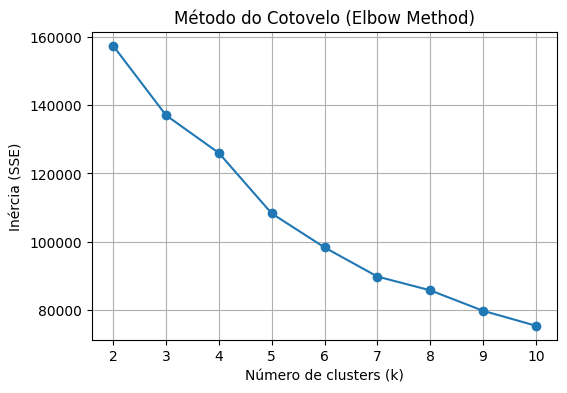

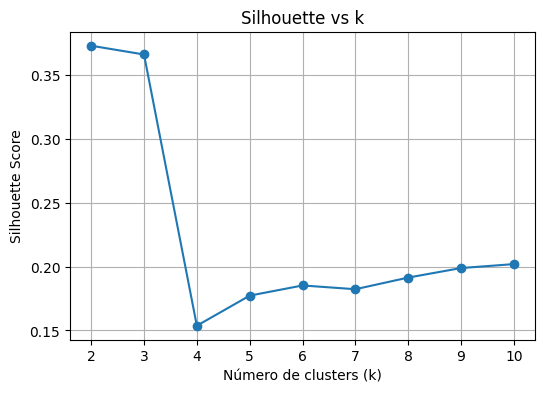

K selecionado (maior silhouette): 2
Silhouette Score para k=2: 0.3727


In [ ]:
K_RANGE = range(2, 11)
inertias, silhouettes = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)
    labels = km.labels_
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else np.nan
    silhouettes.append(sil)

plt.figure(figsize=(6,4))
plt.plot(list(K_RANGE), inertias, marker="o"); plt.grid(True)
plt.xlabel("Número de clusters (k)"); plt.ylabel("Inércia (SSE)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.savefig("elbow_method.png", dpi=300, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(K_RANGE), silhouettes, marker="o"); plt.grid(True)
plt.xlabel("Número de clusters (k)"); plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k")
plt.savefig("silhouette_scores.png", dpi=300, bbox_inches="tight"); plt.show()

k_list = np.array(list(K_RANGE))
sil_arr = np.array(silhouettes, dtype=float)
best_k = int(k_list[np.nanargmax(sil_arr)])
best_silhouette = float(np.nanmax(sil_arr))

print(f"K selecionado (maior silhouette): {best_k}")
print(f"Silhouette Score para k={best_k}: {best_silhouette:.4f}")

k_diag = pd.DataFrame({"k": k_list, "inercia": inertias, "silhouette": silhouettes})
k_diag.to_csv("k_diagnostics.csv", index=False)


4) Modelo de Clusterização

Com o número ideal de clusters definido, treinamos o algoritmo K-Means. Cada cliente foi atribuído a um cluster, agrupando aqueles com características semelhantes. Essa etapa gera uma nova coluna chamada cluster, que pode ser utilizada em análises posteriores ou visualizações.

In [ ]:
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(X)
df["cluster"] = kmeans.labels_

cols_exist = [c for c in [
    "nps_rel_medio","nps_trans_medio","tick_qtd",
    "tick_tempo_medio_resolucao_dias","tick_close_rate","mrr_12m"
] if c in df.columns]

perfil_cluster = (
    df.groupby("cluster")
      .agg(qtd_clientes=("clienteid","nunique"),
           **{f"{c}_medio": (c,"mean") for c in cols_exist})
      .reset_index()
      .sort_values("qtd_clientes", ascending=False)
)

# exports pro BI
out_clientes = df[["clienteid","cluster"]].merge(base, on="clienteid", how="left")
out_clientes.to_csv("clientes_com_clusters.csv", index=False)
perfil_cluster.to_csv("resumo_clusters.csv", index=False)

print("Gerados: elbow_method.png, silhouette_scores.png, k_diagnostics.csv, clientes_com_clusters.csv, resumo_clusters.csv")


Gerados: elbow_method.png, silhouette_scores.png, k_diagnostics.csv, clientes_com_clusters.csv, resumo_clusters.csv


In [ ]:

Z = df[num_cols].apply(zscore, nan_policy="omit")
Z["cluster"] = df["cluster"].values

cluster_z = Z.groupby("cluster")[num_cols].mean().round(2)
cluster_z.to_csv("cluster_zscores.csv")
display(cluster_z)

top_features = {}
for c_id, row in cluster_z.iterrows():
    top_plus = row.sort_values(ascending=False).head(5)
    top_minus = row.sort_values(ascending=True).head(5)
    top_features[c_id] = {
        "acima_media": top_plus.index.tolist(),
        "abaixo_media": top_minus.index.tolist()
    }

print("Arquivo salvo: cluster_zscores.csv")
top_features


,vl_total_contrato,mrr_12m,tel_total_eventduration,tel_n_modulos_distintos,tel_n_productlines_distintos,tel_dias_desde_ultimo_uso,tel_pct_licenca_ativa,tel_pct_cloud,tel_pct_prime,tick_qtd,tick_tempo_medio_resolucao_dias,tick_close_rate,nps_rel_medio,nps_rel_qtd,nps_aq_medio,nps_aq_qtd,nps_impl_medio,nps_impl_qtd,nps_onb_medio,nps_onb_qtd,nps_prod_medio,nps_prod_qtd,nps_supp_medio,nps_supp_qtd,nps_trans_qtd,nps_trans_medio
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.02,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.15,-0.05,-0.17,NaN,NaN,-0.06,-0.06,-0.11,-0.11,NaN,NaN,-0.47,-0.16,NaN,NaN,-0.16,-0.48
1,0.08,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59,0.20,0.69,NaN,NaN,0.25,0.24,0.43,0.43,NaN,NaN,1.89,0.64,NaN,NaN,0.64,1.95


Arquivo salvo: cluster_zscores.csv


{0: {'acima_media': ['vl_total_contrato',
   'tick_tempo_medio_resolucao_dias',
   'nps_aq_medio',
   'nps_aq_qtd',
   'nps_impl_medio'],
  'abaixo_media': ['nps_trans_medio',
   'nps_prod_medio',
   'tick_close_rate',
   'nps_trans_qtd',
   'nps_prod_qtd']},
 1: {'acima_media': ['nps_trans_medio',
   'nps_prod_medio',
   'tick_close_rate',
   'nps_prod_qtd',
   'nps_trans_qtd'],
  'abaixo_media': ['vl_total_contrato',
   'tick_tempo_medio_resolucao_dias',
   'nps_aq_qtd',
   'nps_aq_medio',
   'nps_impl_medio']}}

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

labels = df["cluster"].values
sil_samples = silhouette_samples(X, labels)
sil_overall = silhouette_score(X, labels)

sil_by_cluster = pd.Series(sil_samples).groupby(labels).mean().round(4)

print(f"Silhouette médio geral: {sil_overall:.4f}")
print(sil_by_cluster.rename("silhouette_medio"))


Silhouette médio geral: 0.3727
0    0.4669
1   -0.0077
Name: silhouette_medio, dtype: float64


In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans.fit(X)

df["cluster"] = kmeans.labels_

summary_num = df.groupby("cluster")[num_cols].mean().round(2) if len(num_cols) else pd.DataFrame()
count_cluster = df["cluster"].value_counts().sort_index().rename("qtd_clientes")
perfil_cluster = count_cluster.to_frame().join(summary_num, how="left")

perfil_cluster


,qtd_clientes,vl_total_contrato,mrr_12m,tel_total_eventduration,tel_n_modulos_distintos,tel_n_productlines_distintos,tel_dias_desde_ultimo_uso,tel_pct_licenca_ativa,tel_pct_cloud,tel_pct_prime,tick_qtd,tick_tempo_medio_resolucao_dias,tick_close_rate,nps_rel_medio,nps_rel_qtd,nps_aq_medio,nps_aq_qtd,nps_impl_medio,nps_impl_qtd,nps_onb_medio,nps_onb_qtd,nps_prod_medio,nps_prod_qtd,nps_supp_medio,nps_supp_qtd,nps_trans_qtd,nps_trans_medio
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8509,1726.52,3.111436e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.06,10.46,0.28,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.02,0.02,0.0,0.0,0.02,0.02
1,2106,4654.89,1.093971e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220.95,24.93,0.48,0.0,0.0,0.18,0.02,0.49,0.08,0.0,0.0,7.34,16.80,0.0,0.0,16.90,7.77


Visualização PCA 2D

Aplicamos PCA para reduzir a dimensionalidade e gerar um gráfico 2D dos clusters (clusters_pca2d.png/.csv). Essa visão facilita a comunicação dos resultados e inspeção de separação entre grupos.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


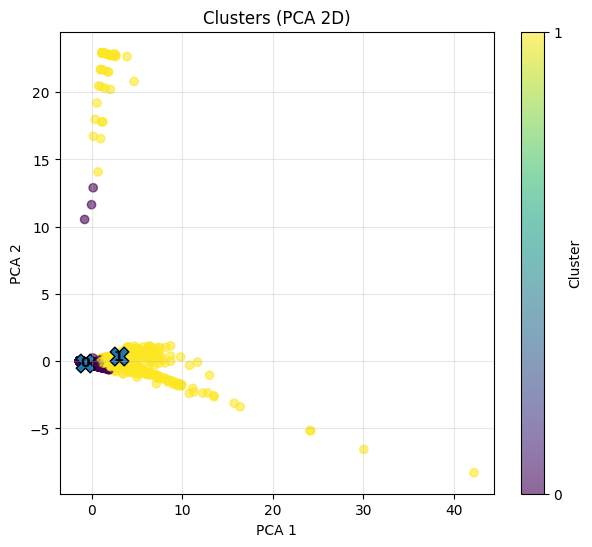

Arquivos gerados: clientes_com_clusters.csv, resumo_clusters.csv, clusters_pca2d.png


In [ ]:


if X.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(X)

    plt.figure(figsize=(7,6))
    sc = plt.scatter(coords[:,0], coords[:,1], c=df["cluster"], alpha=0.6)
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.title("Clusters (PCA 2D)")
    plt.grid(True, alpha=0.3)

    cbar = plt.colorbar(sc, ticks=sorted(df["cluster"].unique()))
    cbar.set_label("Cluster")

    try:
        centroids_pca = pca.transform(kmeans.cluster_centers_)
        plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker="X", s=180, edgecolor="k")
        for i, (x, y) in enumerate(centroids_pca):
            plt.text(x, y, str(i), fontsize=10, ha="center", va="center", weight="bold")
    except NameError:
        pass

    plt.savefig("clusters_pca2d.png", dpi=300, bbox_inches="tight")
    plt.show()

out_clientes = df[["clienteid","cluster"]].merge(base, on="clienteid", how="left")
out_clientes.to_csv("clientes_com_clusters.csv", index=False)
perfil_cluster.reset_index().to_csv("resumo_clusters.csv", index=False)

print("Arquivos gerados: clientes_com_clusters.csv, resumo_clusters.csv, clusters_pca2d.png")


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

labels = df["cluster"].values
db_index = davies_bouldin_score(X, labels)
ch_index = calinski_harabasz_score(X, labels)

print(f"Davies-Bouldin Index: {db_index:.4f}  (↓ melhor)")
print(f"Calinski-Harabasz Score: {ch_index:.2f}  (↑ melhor)")


Davies-Bouldin Index: 1.7916  (↓ melhor)
Calinski-Harabasz Score: 1794.33  (↑ melhor)
